# Classifying Toxic and Severely Toxic Comments Feed Forward NN

    - 300D fasttext embeddings and 70 max sequence length
    - data set of 30,000 comments (taken from 2017 Kaggle - training and test datasets

### Load Libraries and Data Sets

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

import re

import string     # Imports the library
import nltk        # Imports the natural language toolkit
from nltk.corpus import stopwords

#nltk.download('stopwords')   # Download the stopwords dataset
#nltk.download('wordnet')

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
#tfds.list_builders()

#### Load 2017 Train Data Set

In [3]:
df_train_wiki_tox = pd.read_csv("train.csv")

#### Load 2017 Test Data Set and Test Labels

In [4]:
df_test_wiki_tox = pd.read_csv("test.csv")
df_test_wiki_tox_labels= pd.read_csv("test_labels.csv")

##### 2017 Test Labels with a Values of -1 were not used for scoring

In [5]:
df_test_wiki_tox_labels['toxic'].value_counts()

-1    89186
 0    57888
 1     6090
Name: toxic, dtype: int64

In [6]:
df_labelled_test = df_test_wiki_tox_labels[df_test_wiki_tox_labels['toxic']>-1]
df_labelled_test=df_labelled_test.reset_index()
df_labelled_test.pop('index')
df_labelled_test.head(3)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,0,0,0,0,0,0
1,000247e83dcc1211,0,0,0,0,0,0
2,0002f87b16116a7f,0,0,0,0,0,0


In [7]:
df_labelled_test['toxic'].value_counts()

0    57888
1     6090
Name: toxic, dtype: int64

In [8]:
##### Values with a -1 were not used for scoring

In [9]:
def text_process_1(text):
    #text=text.decode('utf-8')
    
    # Replace the xa0 with a space
    text=text.replace('xa0',' ')
    # Replace the \xa0 with a space
    text=text.replace('\xa0',' ')
    # Replace the \n\n with a space
    text=text.replace('\n\n',' ')
    # Replace the \n with a space
    text=text.replace('\n',' ')
    # Replace apostrophes with nothing
    text=text.replace('\'','')
    # Replace http with a space
    text=text.replace('http','')
    
    tokens = nltk.word_tokenize(text)
    
    cleaned_words=[w.lower() for w in tokens if w.isalnum()]
    #remove any words that are actually digits. 
    no_integers = [x for x in cleaned_words if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
    no_integers = ' '.join(no_integers)
    
    return no_integers

In [10]:
import time
t_start = time.time()

df_train_wiki_tox['clean']=df_train_wiki_tox['comment_text'].apply(lambda x: text_process_1(x))


t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 59.857 seconds


In [11]:
import time
t_start = time.time()

df_train_wiki_tox['wd_len']=df_train_wiki_tox['clean'].apply(lambda x: len(nltk.word_tokenize(x)))

t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 27.167 seconds


In [12]:
df_small = df_train_wiki_tox[(df_train_wiki_tox['wd_len']<300) & (df_train_wiki_tox['wd_len']>10)]
df_small=df_small.reset_index()
df_small.pop('index')

0              0
1              1
2              2
3              3
4              4
           ...  
129495    159566
129496    159567
129497    159568
129498    159569
129499    159570
Name: index, Length: 129500, dtype: int64

In [13]:
df_small['severe_toxic'].value_counts()

0    128540
1       960
Name: severe_toxic, dtype: int64

In [14]:
from sklearn import preprocessing
# instatiate sklearn's labelencoder
le = preprocessing.LabelEncoder()

# fit label encorder and return encoded integer labels for categorical string features
df_small['new_severe_toxic'] = le.fit_transform(df_small['severe_toxic'].values)
df_small['new_severe_toxic'].value_counts()
#df_3.pop('Results')



0    128540
1       960
Name: new_severe_toxic, dtype: int64

In [15]:
# fit label encorder and return encoded integer labels for categorical string features
df_small['new_toxic'] = le.fit_transform(df_small['toxic'].values)
df_small['new_toxic'].value_counts()
#df_3.pop('Results')

0    118412
1     11088
Name: new_toxic, dtype: int64

In [16]:
df_small['new_toxic'].head(100)

0     0
1     0
2     0
3     0
4     0
     ..
95    0
96    0
97    0
98    0
99    0
Name: new_toxic, Length: 100, dtype: int64

In [17]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

undersample_2 = RandomUnderSampler(sampling_strategy='majority')

#### Toxic Comments Classification - Under Sample Majority Class 

In [18]:
#https://stackoverflow.com/questions/53723928/attributeerror-series-object-has-no-attribute-reshape
X=df_small['clean']
X=X.values.reshape(-1, 1)

Y=df_small['new_toxic']
Y=Y.values.reshape(-1, 1)

X_under, y_under = undersample.fit_resample(X, Y)
new_x=pd.DataFrame(X_under)[0]
new_y=pd.DataFrame(y_under)[0]

#### Severely Toxic Comments Classification - Under Sample Majority Class 

In [19]:
X_2=df_small['clean']
X_2=X_2.values.reshape(-1, 1)

Y_2=df_small['new_severe_toxic']
Y_2=Y_2.values.reshape(-1, 1)

X_under_2, y_under_2 = undersample_2.fit_resample(X_2, Y_2)
new_x_2=pd.DataFrame(X_under_2)[0]
new_y_2=pd.DataFrame(y_under_2)[0]

### Load Pre-trained Glove and Word2Vec embeddings

In [20]:
import numpy as np # linear algebra
import os, sys

from gensim.models import Word2Vec, KeyedVectors
from gensim.test.utils import datapath

C:\Users\Rober\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [21]:
import time
t_start = time.time()


# Get path to file
vector_size = 768
#glove_file = '../input/glove-reddit-comments/GloVeReddit120B/GloVe.Reddit.120B.300D.txt'

glove_file ='GloVe.Reddit.120B.768D.txt'

# Load with gensim
model = KeyedVectors.load_word2vec_format(glove_file)

t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 444.093 seconds


### Create Sentence Vector for each comment by Averaging the Word Vectors

In [22]:
#average first 30 words in the sentence
def sent_vectorizer_1(text):
    n=len(text)
    text_1=text[0:n]
    vectors = [model[x] for x in text_1.split(' ') if x in model.key_to_index]
    #sent_vector=sum(vectors)/len(vectors)
    if len(vectors) != 0:
        sent_vector=sum(vectors)/len(vectors)
    elif len(text) !=0:
        sent_vector=sum(vectors)/len(text)
    else:
        sent_vector=sum(vectors)/1
    return sent_vector

### Regular Toxic - Binary Classification

In [23]:
import time
t_start = time.time()

df_glove=pd.DataFrame(new_x)
df_glove.columns=['text']
df_glove['sent_vec_1']=df_glove['text'].apply(lambda x: sent_vectorizer_1(x))


t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 1.933 seconds


#### Creates Data Frame where 1 sentence is 1 Row, with 300 columns

In [24]:
import time
t_start = time.time()

X_glove=df_glove['sent_vec_1']


ddd=pd.DataFrame()


for idx, row in enumerate(X_glove):
    #print((roww))
    #print(list(roww))
    row_df=pd.Series(X_glove[idx]).to_frame()
    row_df_2=row_df.T
    ddd=pd.concat([ddd, row_df_2])
    #row_df= pd.DataFrame(roww)
#     row_df_2=row_df.T
#     ddd=pd.concat([ddd, row_df_2])
    
t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 156.844 seconds


In [25]:
df_glove_avg=ddd.reset_index()
df_glove_avg.pop('index')
df_glove_avg

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.242870,0.131449,-0.107705,0.320499,0.007212,0.097709,-0.015212,-0.271593,-0.259828,0.243551,...,-0.087860,-0.174656,-0.024902,-0.056367,0.212878,0.071195,0.235152,0.141611,0.320514,-0.136405
1,0.196283,0.100883,0.024023,0.319634,0.025133,0.017234,0.046166,-0.228039,-0.322698,0.139684,...,-0.023608,-0.102434,0.001398,-0.043210,0.218588,0.063392,0.207331,0.110252,0.329420,-0.128522
2,0.159607,0.053702,-0.053313,0.328310,0.013514,0.071124,0.054514,-0.295954,-0.228510,0.181548,...,-0.089041,-0.243265,-0.093468,-0.100837,0.099590,0.059758,0.258803,0.227810,0.329855,0.007674
3,0.184424,0.142577,0.060167,0.316908,-0.006080,-0.025332,0.077740,-0.092789,-0.291551,0.169173,...,-0.111860,-0.258467,0.070231,-0.047733,0.247660,0.048386,0.128783,0.258839,0.231050,-0.146527
4,0.143451,0.155883,-0.008247,0.256016,-0.023946,0.071156,0.040974,-0.159580,-0.219370,0.122882,...,0.016177,-0.144987,0.005202,-0.058776,0.177307,0.178435,0.079509,0.125829,0.256261,-0.044420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22171,0.070590,0.184251,0.148726,0.227605,-0.036799,0.090182,-0.019065,-0.080726,-0.148066,0.112775,...,-0.068538,-0.175033,-0.021848,0.052516,0.161386,0.152665,0.069327,0.119267,0.068508,-0.104586
22172,0.193001,0.137727,-0.095725,0.298201,-0.006982,0.036559,0.015717,-0.252593,-0.270821,0.181729,...,-0.116324,-0.198409,-0.060868,-0.081872,0.167197,0.034176,0.176308,0.160164,0.307432,-0.073194
22173,0.108760,0.160298,-0.024049,0.274953,-0.028314,0.103392,0.023290,-0.240156,-0.234149,0.178782,...,-0.045383,-0.182914,-0.039025,0.009336,0.101688,-0.001995,0.229467,0.083900,0.321072,-0.110207
22174,0.182227,0.136645,0.006006,0.274468,-0.070426,0.083001,0.040703,-0.257833,-0.218978,0.148253,...,-0.036964,-0.249743,-0.076993,-0.029553,0.109465,0.006678,0.172726,0.188526,0.317873,-0.075924


### Severely Toxic - Binary Classification

In [26]:
import time
t_start = time.time()

df_glove_2=pd.DataFrame(new_x_2)
df_glove_2.columns=['text']
df_glove_2['sent_vec_1']=df_glove_2['text'].apply(lambda x: sent_vectorizer_1(x))


t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 0.159 seconds


#### Creates Data Frame where 1 sentence is 1 Row, with 300 columns

In [27]:
import time
t_start = time.time()

X_glove_2=df_glove_2['sent_vec_1']


ddd_2=pd.DataFrame()


for idx, row in enumerate(X_glove_2):
    #print((roww))
    #print(list(roww))
    row_df=pd.Series(X_glove_2[idx]).to_frame()
    row_df_2=row_df.T
    ddd_2=pd.concat([ddd_2, row_df_2])
    #row_df= pd.DataFrame(roww)
#     row_df_2=row_df.T
#     ddd=pd.concat([ddd, row_df_2])
    
t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 1.661 seconds


In [28]:
df_glove_avg_2=ddd_2.reset_index()
df_glove_avg_2.pop('index')
df_glove_avg_2

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.139505,0.209424,-0.077699,0.223548,0.050342,0.037103,0.021646,-0.187813,-0.229208,0.183360,...,-0.200423,-0.251564,0.048446,0.023519,0.153085,0.048995,0.051401,0.071645,0.375047,-0.249778
1,0.043859,0.052107,0.033720,0.268563,0.094735,-0.001022,0.103828,-0.185062,-0.225251,0.114381,...,-0.034442,-0.112618,-0.006056,-0.087528,0.124143,0.049035,0.080996,0.218682,0.211571,-0.112268
2,0.230726,0.127102,-0.240991,0.245846,-0.010206,0.094918,0.023424,-0.246917,-0.237928,0.233365,...,-0.063685,-0.230254,-0.078524,-0.118252,0.088202,0.049085,0.347878,0.150734,0.307196,-0.161278
3,0.202484,0.068819,-0.123172,0.283378,-0.001665,0.070793,0.050725,-0.257738,-0.332114,0.136249,...,-0.075067,-0.213559,-0.068177,-0.020466,0.224159,0.055408,0.197314,0.097697,0.291464,-0.086299
4,0.173726,0.106720,-0.079369,0.343766,0.064285,0.112556,0.073694,-0.300140,-0.338789,0.173898,...,-0.090132,-0.282990,-0.004665,-0.065712,0.145021,0.031120,0.202322,0.154118,0.333287,-0.116213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,0.130006,0.148804,0.025668,0.315933,0.018069,0.053613,0.020305,-0.271441,-0.187216,0.203027,...,-0.106874,-0.302112,-0.095020,-0.036616,0.132814,0.115247,0.188482,0.127314,0.263097,-0.053509
1916,0.178438,0.111089,0.012240,0.267302,-0.039646,0.004379,0.075273,-0.200056,-0.225321,0.188660,...,-0.014491,-0.286461,-0.045289,0.013030,0.109549,0.114436,0.199389,0.114402,0.175274,-0.121816
1917,0.192788,0.151579,0.069655,0.338342,-0.006035,0.074350,-0.044841,-0.217161,-0.245617,0.212375,...,-0.024782,-0.330665,-0.098308,-0.039067,0.138595,-0.002634,0.260221,0.172287,0.375000,-0.052259
1918,0.130645,0.070156,0.015310,0.148470,0.015476,0.035313,-0.045381,-0.159669,-0.197916,0.131888,...,-0.066757,-0.171472,0.100926,-0.014554,0.122199,0.079353,0.161350,0.053929,0.176666,-0.081431


#### import necessary tools and models 

In [29]:
# import necessary tools and models 
import seaborn as sns
import matplotlib.pyplot as plt 

import sklearn.model_selection as cv
from sklearn.model_selection import cross_val_score
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

#### Glove Reddit 768 - separate train - test data

In [30]:
# Regular Toxic - separate train - test data 
X_train_g200, X_test_g200, y_train_g200, y_test_g200 = cv.train_test_split(df_glove_avg, new_y,test_size=0.33)

# Severely Toxic - separate train - test data 
X_train_g200_2, X_test_g200_2, y_train_g200_2, y_test_g200_2 = cv.train_test_split(df_glove_avg_2, new_y_2,test_size=0.33)

In [31]:
pd.DataFrame(new_y)[0].value_counts()

0    11088
1    11088
Name: 0, dtype: int64

# Build Deep Learning Models

In [32]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import keras
import tensorflow

import tensorflow.keras
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import numpy as np




import keras.utils
from keras import utils as np_utils

from keras.utils import np_utils

#### Compile and Train Model for Regular Toxicity 

In [33]:
# Fit model
epochs = 150
batch_size=32
#early_stopping_monitor = EarlyStopping(patience=300)

In [34]:
#get number of columns in training data
n_cols = X_train_g200.shape[1]
#n_cols = X_train_tfidf.shape[1]

DL_model = keras.models.Sequential([
    keras.layers.Dense(512, activation="relu",input_shape=(n_cols,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation="relu",input_shape=(n_cols,)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation="relu",input_shape=(n_cols,)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation="sigmoid")
    ])

In [35]:
DL_model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy'])
DL_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               393728    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

In [36]:
my_callbacks = [
    EarlyStopping(patience=5),
    ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.4f}.h5'),
    TensorBoard(log_dir='logs'),
]

In [37]:
#train model
history = DL_model.fit(X_train_g200, y_train_g200, 
                    epochs=epochs, batch_size=batch_size, shuffle=True,
                    validation_split=0.2, callbacks=my_callbacks)

Epoch 1/150
372/372 [==============================] - 3s 6ms/step - loss: 0.4531 - accuracy: 0.7757 - val_loss: 0.3047 - val_accuracy: 0.8745
Epoch 2/150
372/372 [==============================] - 2s 5ms/step - loss: 0.3389 - accuracy: 0.8589 - val_loss: 0.2825 - val_accuracy: 0.8762
Epoch 3/150
372/372 [==============================] - 2s 5ms/step - loss: 0.3181 - accuracy: 0.8682 - val_loss: 0.2920 - val_accuracy: 0.8641
Epoch 4/150
372/372 [==============================] - 2s 5ms/step - loss: 0.3042 - accuracy: 0.8765 - val_loss: 0.2680 - val_accuracy: 0.8863
Epoch 5/150
372/372 [==============================] - 2s 6ms/step - loss: 0.3004 - accuracy: 0.8772 - val_loss: 0.2636 - val_accuracy: 0.8869
Epoch 6/150
372/372 [==============================] - 3s 7ms/step - loss: 0.2870 - accuracy: 0.8789 - val_loss: 0.2678 - val_accuracy: 0.8869
Epoch 7/150
372/372 [==============================] - 3s 7ms/step - loss: 0.2937 - accuracy: 0.8793 - val_loss: 0.2571 - val_accuracy: 0.8866

In [58]:
#testing
scores = DL_model.evaluate(X_test_g200, y_test_g200, batch_size=32, verbose=1)
print('Test result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

229/229 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.8925
Test result: 89.247 loss: nan


### Plot the loss curve

<Figure size 864x288 with 0 Axes>

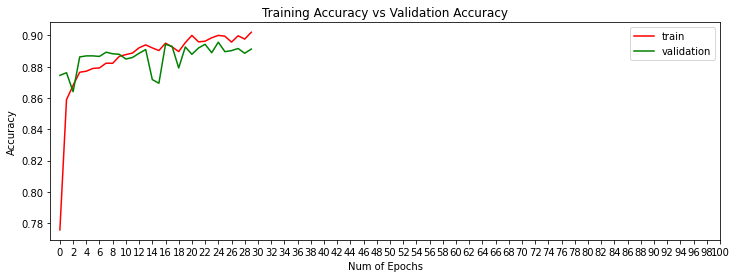

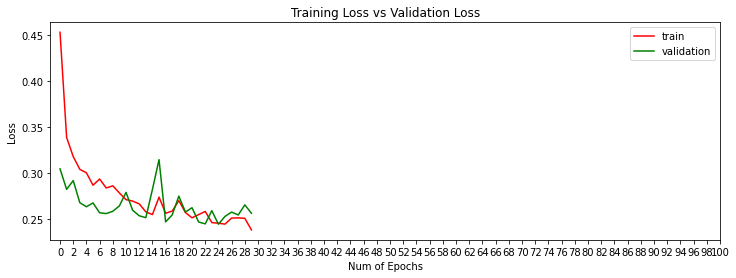

In [59]:
plt.figure(221)

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
 
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

### Compile and Train Model for Severe Toxicity 

In [60]:
# Fit model
epochs_2 = 200
batch_size_2 =32
#early_stopping_monitor_2 = EarlyStopping(patience=300)

In [61]:
#get number of columns in training data
n_cols_2 = X_train_g200_2.shape[1]
#n_cols = X_train_tfidf.shape[1]

DL_model_2 = keras.models.Sequential([
#     keras.layers.Dense(256, activation="relu",input_shape=(n_cols,)),
#     keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation="relu",input_shape=(n_cols_2,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
     keras.layers.Dense(10, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation="sigmoid")
    ])

In [62]:
DL_model_2.compile(loss=keras.losses.binary_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy'])
DL_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               98432     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
_________________________________________________________________
dropout_9 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

In [63]:
my_callbacks_2 = [
    EarlyStopping(patience=5),
    ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    TensorBoard(log_dir='logs'),
]

In [64]:
#train model
history_2 = DL_model_2.fit(X_train_g200_2, y_train_g200_2, 
                    epochs=epochs_2, batch_size=batch_size_2, shuffle=True,
                    validation_split=0.2, callbacks=my_callbacks_2)

Epoch 1/200
33/33 [==============================] - 1s 12ms/step - loss: 0.6823 - accuracy: 0.5720 - val_loss: 0.6370 - val_accuracy: 0.8217
Epoch 2/200
33/33 [==============================] - 0s 7ms/step - loss: 0.5971 - accuracy: 0.6605 - val_loss: 0.4655 - val_accuracy: 0.8837
Epoch 3/200
33/33 [==============================] - 0s 7ms/step - loss: 0.4793 - accuracy: 0.7870 - val_loss: 0.3259 - val_accuracy: 0.9031
Epoch 4/200
33/33 [==============================] - 0s 6ms/step - loss: 0.4078 - accuracy: 0.8288 - val_loss: 0.2662 - val_accuracy: 0.8992
Epoch 5/200
33/33 [==============================] - 0s 6ms/step - loss: 0.3520 - accuracy: 0.8794 - val_loss: 0.2265 - val_accuracy: 0.9186
Epoch 6/200
33/33 [==============================] - 0s 6ms/step - loss: 0.3080 - accuracy: 0.8940 - val_loss: 0.2132 - val_accuracy: 0.9341
Epoch 7/200
33/33 [==============================] - 0s 6ms/step - loss: 0.2930 - accuracy: 0.9095 - val_loss: 0.2115 - val_accuracy: 0.9225
Epoch 8/200


In [65]:
#testing
scores_2 = DL_model_2.evaluate(X_test_g200_2, y_test_g200_2, batch_size=32, verbose=1)
print('Test result: %.3f loss: %.3f' % (scores_2[1]*100,scores_2[0]))

20/20 [==============================] - 0s 2ms/step - loss: 0.1900 - accuracy: 0.9416
Test result: 94.164 loss: 0.190


In [66]:
#save model to disk
model_json = DL_model_2.to_json()
with open('model_ann_severe_toxic.json', 'w') as json_file:
    json_file.write(model_json)
DL_model_2.save_weights('model_ann_severe_toxic.h5') 

<Figure size 864x288 with 0 Axes>

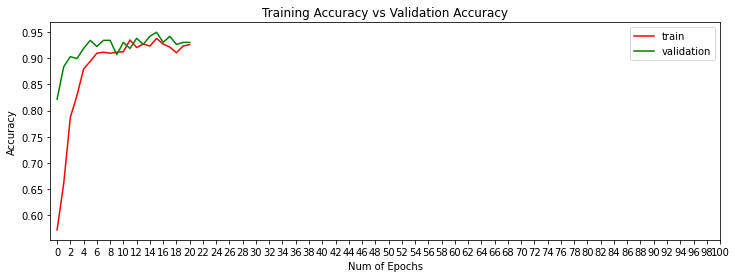

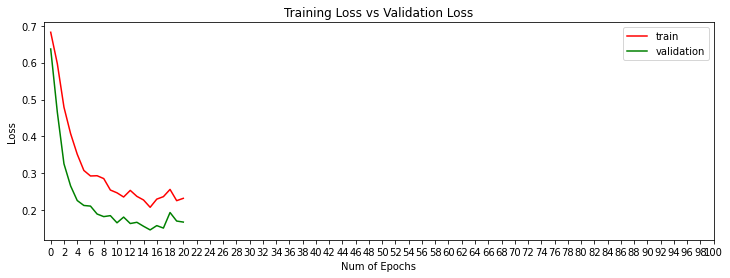

In [67]:
plt.figure(221)

plt.figure(0)
plt.plot(history_2.history['accuracy'],'r')
plt.plot(history_2.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
 
plt.figure(1)
plt.plot(history_2.history['loss'],'r')
plt.plot(history_2.history['val_loss'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

# Submission Data Set

In [68]:
df_test = pd.read_csv('comments_to_score.csv',low_memory = False) 

In [69]:
import time
t_start = time.time()

df_test['clean']=df_test['text'].apply(lambda x: text_process_1(x))


t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 3.118 seconds


In [70]:
import time
t_start = time.time()

df_test['sent_vec_1']=df_test['clean'].apply(lambda x: sent_vectorizer_1(x))

t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 0.874 seconds


In [71]:
X_test=df_test['sent_vec_1']
X_test

0       [0.13326274, 0.14546841, -0.063406445, 0.28416...
1       [0.035241537, 0.10603623, -0.003508845, 0.3954...
2       [0.1593038, 0.03433154, -0.04458427, 0.3040714...
3       [0.17278722, 0.11127991, -0.089476526, 0.30726...
4       [0.027981045, 0.15911521, -0.066612594, 0.3736...
                              ...                        
7532    [0.2862072, 0.2617116, 0.0895114, 0.28348678, ...
7533    [0.095424995, 0.084042594, -0.20972502, 0.3486...
7534    [0.19862935, 0.15869436, -0.07644144, 0.363083...
7535    [0.13331321, 0.1968919, -0.0380373, 0.28607768...
7536    [0.07088007, 0.13425708, -0.13204664, 0.273186...
Name: sent_vec_1, Length: 7537, dtype: object

In [72]:
import time
t_start = time.time()

df_test_fin=pd.DataFrame()


for idx, row in enumerate(X_test):
    #print((roww))
    #print(list(roww))
    row_df=pd.Series(X_test[idx]).to_frame()
    row_df_2=row_df.T
    df_test_fin=pd.concat([df_test_fin, row_df_2])
    #row_df= pd.DataFrame(roww)
#     row_df_2=row_df.T
#     ddd=pd.concat([ddd, row_df_2])

df_test_fin = df_test_fin.fillna(0)

t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 20.174 seconds


In [73]:
test_ids=df_test['comment_id']
test_ids

0          114890
1          732895
2         1139051
3         1434512
4         2084821
          ...    
7532    504235362
7533    504235566
7534    504308177
7535    504570375
7536    504598250
Name: comment_id, Length: 7537, dtype: int64

#### Predict Severe Toxicity

In [74]:
Y_test_pred_Sev_tox=DL_model_2.predict(df_test_fin)
Y_test_pred_Sev_tox_2=pd.DataFrame(Y_test_pred_Sev_tox)
Y_test_pred_Sev_tox_2

,0
0,0.005888
1,0.051260
2,0.008077
3,0.004620
4,0.018549
...,...
7532,0.969363
7533,0.006829
7534,0.029375
7535,0.823981


#### Predict Regular Toxicity

In [75]:
Y_test_pred_reg_tox=DL_model.predict(df_test_fin)
Y_test_pred_reg_tox_2=pd.DataFrame(Y_test_pred_reg_tox)
Y_test_pred_reg_tox_2

,0
0,0.028624
1,0.295218
2,0.092581
3,0.016377
4,0.916837
...,...
7532,0.999897
7533,0.437839
7534,0.411777
7535,0.999841


In [76]:
df_merge=pd.concat([test_ids, Y_test_pred_reg_tox_2, Y_test_pred_Sev_tox_2], axis=1)
df_merge.columns=["comment_id","b","d"]

df_merge['score']=df_merge['b']+df_merge['d']
df_merge.pop('b')
df_merge.pop('d')
df_merge

,comment_id,score
0,114890,0.034512
1,732895,0.346478
2,1139051,0.100658
3,1434512,0.020997
4,2084821,0.935386
...,...,...
7532,504235362,1.969260
7533,504235566,0.444668
7534,504308177,0.441151
7535,504570375,1.823822


In [77]:
df_merge.to_csv('submission.csv', index=False)